In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import sys

from PIL import Image
from tqdm import tqdm

# Test Generating MRI Data Array

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 451/451 [01:07<00:00,  6.70it/s]


Output Array Shape(451, 60, 256, 256)
Output Array Size: 14187233280 bytes
Output Array Size: 13 GiB


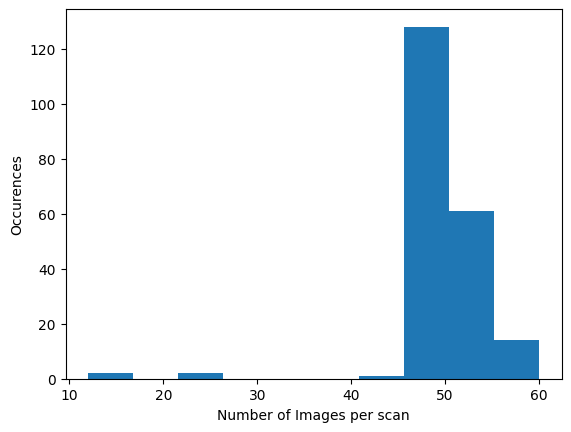

In [2]:
def get_file_list(directory) -> list:
    return os.listdir(directory)

DATA_PATH = 'data/mri_data_pool'

patient_list = get_file_list(DATA_PATH)

output_list = list()

list_of_image_quantities = list()

for i in tqdm(range(len(patient_list))):
    patient_id = patient_list[i]
    
    PATIENT_ID_PATH = DATA_PATH + "/" + patient_id
    
    scan_list = get_file_list(PATIENT_ID_PATH)
    
    for scan_group in scan_list:
        if scan_group != "Axial_PD_T2_FSE":
            continue
        else:
            array_list = list()

            SCAN_PATH = PATIENT_ID_PATH + "/" + scan_group

            date_list = get_file_list(SCAN_PATH)

            date_list.sort()
            
            is_date_scanned = False
            
            for date in date_list:

                # Use the first date only
                if is_date_scanned:
                    continue
                
                DATE_PATH = SCAN_PATH + "/" + date

                id_list = get_file_list(DATE_PATH)

                for id in id_list:

                    ID_PATH = DATE_PATH + "/" + id
                
                    file_list = get_file_list(ID_PATH)

                    list_of_image_quantities.append(len(file_list))
                    
                    for file_name in file_list:
                        np.set_printoptions()
                        file_path = ID_PATH + "/" + file_name
        
                        dcm = pydicom.dcmread(file_path)
                        
                        pixel_array = dcm.pixel_array
                        
                        #print(pixel_array.shape)
                        array_list.append(pixel_array)

                    # Fill missing spaces with arrays
                    cur_len = len(array_list)
                    
                    for j in range(60-cur_len):
                        array_list.append(np.zeros(shape=(256, 256)))
                        
                is_date_scanned = True

    output_list.append(array_list)

output_array = np.array(output_list)
print("Output Array Shape" + str(output_array.shape))
print("Output Array Size: %d bytes" % (output_array. size * output_array. itemsize))
print("Output Array Size: %d GiB" % (output_array. size * output_array. itemsize / 1073741824))

plt.hist(list_of_image_quantities)
plt.xlabel('Number of Images per scan')
plt.ylabel('Occurences')
plt.show()

In [3]:
max(list_of_image_quantities)

60

In [4]:
# get list of patients in AD_time_to_dx.csv file

df_labels = pd.read_csv("data/AD_time_to_dx.csv")

patient_list = df_labels["PTID"].values

print(*patient_list, sep=", ")

022_S_0004, 011_S_0005, 100_S_0006, 022_S_0014, 100_S_0015, 011_S_0016, 067_S_0019, 011_S_0021, 011_S_0022, 011_S_0023, 023_S_0030, 023_S_0031, 035_S_0033, 100_S_0035, 067_S_0038, 099_S_0040, 007_S_0041, 023_S_0042, 018_S_0043, 100_S_0047, 035_S_0048, 123_S_0050, 099_S_0051, 099_S_0054, 067_S_0056, 018_S_0057, 023_S_0058, 067_S_0059, 099_S_0060, 023_S_0061, 022_S_0066, 010_S_0067, 007_S_0068, 100_S_0069, 007_S_0070, 123_S_0072, 027_S_0074, 067_S_0077, 018_S_0080, 023_S_0081, 136_S_0086, 018_S_0087, 073_S_0089, 099_S_0090, 032_S_0095, 022_S_0096, 020_S_0097, 067_S_0098, 007_S_0101, 123_S_0106, 136_S_0107, 123_S_0108, 099_S_0111, 127_S_0112, 123_S_0113, 027_S_0116, 027_S_0118, 027_S_0120, 131_S_0123, 041_S_0125, 023_S_0126, 068_S_0127, 007_S_0128, 022_S_0130, 021_S_0141, 018_S_0142, 037_S_0150, 018_S_0155, 035_S_0156, 137_S_0158, 021_S_0159, 098_S_0160, 114_S_0166, 011_S_0168, 014_S_0169, 098_S_0171, 098_S_0172, 114_S_0173, 067_S_0176, 067_S_0177, 027_S_0179, 136_S_0184, 136_S_0186, 032_

# Script to get patient ids and scan dates

In [ ]:

def get_file_list(directory) -> list:
    return os.listdir(directory)

METADATA_ROOT_PATH = "data/scan_metadata/"

df = None


# dictionary with list object in values
df_dict = {
    'patient_id' : [],
    'group' : [],
    'scan_date' : []
}

patient_ids = get_file_list(METADATA_ROOT_PATH)

for pid in patient_ids:
    GROUP_DIR_PATH = METADATA_ROOT_PATH + "/" + pid

    group_list = get_file_list(GROUP_DIR_PATH)

    for group in group_list:
        DATE_PATH = GROUP_DIR_PATH + "/" + group
    
        date_list = get_file_list(DATE_PATH)
    
        for date in date_list:
            df_dict["patient_id"].append(pid)
            df_dict["group"].append(group)
            df_dict["scan_date"].append(date)
            

# creating a Dataframe object 
df = pd.DataFrame(df_dict)

df.to_csv("\data\adni_patient_scan_dates.csv")

print(df.head())



# Functions and Constants

In [ ]:

def get_file_list(directory) -> list:
    return os.listdir(directory)

def generate_dataframe(main_directory) -> pd.DataFrame:
    df = pd.DataFrame()
    labels_list = list()
    
    directory_list = get_file_list(main_directory)
    
    for directory in directory_list:
        folder_path = main_directory + "/" + directory
        file_list = get_file_list(folder_path)
        
        n_files = len(file_list)
        
        # Sample 10 files per type
        for i in tqdm(range(10)): #n_files
            file = file_list[i]
            file_path = folder_path + "/" + file
            
            img = Image.open(file_path)
            img_array = np.array(img)
            img_1d = np.reshape(img_array, -1)
            
            df_temp = pd.DataFrame(img_1d)
            df_temp = df_temp.T

            df = df.append(df_temp, ignore_index = True)
            labels_list.append(directory)
    
    df["label"] = pd.Series(labels_list)
    
    return df
    

# Load Data

In [ ]:
df_oasis = None
df_pre = None

df_oasis = generate_dataframe("data/oasis")

In [ ]:
df_oasis.loc[:, (df_oasis != 0).any(axis=0)]